In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import keras
from keras.layers import LSTM, Dense, Activation
from keras.callbacks import EarlyStopping
from keras.models import model_from_json

data = sio.loadmat("Xtrain.mat")["Xtrain"]
print(data.shape)

Using TensorFlow backend.


(1000, 1)


In [2]:
# create a scaler and fit it on data
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data)

data_normed = scaler.transform(data)

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


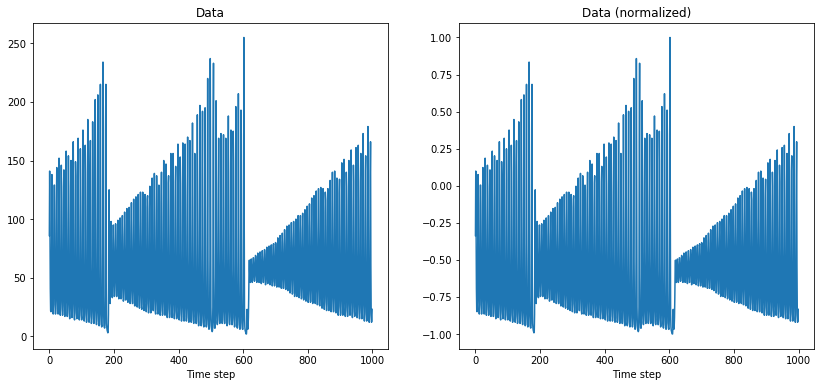

In [3]:
plt.figure(figsize=(14,6))
plt.subplot(121)
plt.plot(data)
plt.title("Data")
plt.xlabel("Time step")

plt.subplot(122)
plt.plot(data_normed)
plt.title("Data (normalized)")
plt.xlabel("Time step")
plt.show()

In [4]:
inputsize = 100

def evaluate_model(inp, target, epochs=1, verbose=2):
    # encode targets

    # define model
    model = keras.Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(inp.shape[1], 1), dropout=0.2, recurrent_dropout=0.2))
    model.add(LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['accuracy'])
    # fit model
    # model.fit(trainX, trainy_enc, epochs=50, verbose=0)
#     early_stopping_monitor = EarlyStopping(monitor='loss', patience=3)
    history = model.fit(inp, target, epochs=epochs, validation_split=0.1, verbose=verbose)
    # evaluate the model
    # _, test_acc = model.evaluate(testX, testY, verbose=0)
    return model, history

def evaluate_single(inp, target, epochs=1, verbose=2, batch_size):
    model = keras.Sequential()
    model.add(LSTM(32, return_sequences=True, input_shape=(inp.shape[1], 1), dropout=0.2, recurrent_dropout=0.2))
    model.add(LSTM(32, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_squared_error',
                  optimizer='adam',
                  metrics=['accuracy'])
    for i in range(epochs):
        history = model.fit(inp, target, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=False)
        model.reset_states()
    return model, history

def persistence(prev_obs, sequence_num):
    return [prev_obs for i in range(sequence_num)]

def forecast(inp, target, n):
    forecasts = list()
    for i in range(len(target)):
        x = target[i, 0:]
        y = target[i, :]
        # make forecast
        forecast = persistence(x[-1], n)
        # store the forecast
        forecasts.append(forecast)
    return forecasts

In [10]:
# def save_model(model):
#     model_json = model.to_json()
# with open("model.json", "w") as json_file:
#     json_file.write(model_json)
# # serialize weights to HDF5
#     model.save_weights("model.h5")
#     print("Saved model")
    
    
def load_model():
    json_file = open('model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights("model.h5")
    print("Loaded model")
    return loaded_model

def eval_loaded_model(loaded_model, inp, target, epochs = 1, verbose = 2, shuffle=False):
    loaded_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    history = model.fit(inp, target, epochs=epochs, validation_split=0.1, verbose=verbose)
    return history 

In [8]:
# Create train and test data (model is trained on sequence and should predict the next timestep)
targetIndex = np.array(range(inputsize, len(data)))

# Compare normalized and not normalized data (data/data_normed)
inputdata = np.array([data_normed[ind-inputsize:ind] for ind in targetIndex])
target = data_normed[targetIndex]

print(f'inputdata Shape {inputdata.shape}')
print(f'target Shape {target.shape}')

# Split into train and test
splitInd = int(len(inputdata)*0.9)
trainX = inputdata[:splitInd]
trainY = target[:splitInd]
testX = inputdata[splitInd:]
testY = target[splitInd:]
print("trainX.shape", trainX.shape)
print("trainY.shape", trainY.shape)
print("testX.shape", testX.shape)
print("testY.shape", testY.shape)

model, history = evaluate_model(trainX, trainY, epochs=50)
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
    model.save_weights("model.h5")
    print("Saved model")



inputdata Shape (900, 100, 1)
target Shape (900, 1)
trainX.shape (810, 100, 1)
trainY.shape (810, 1)
testX.shape (90, 100, 1)
testY.shape (90, 1)
Train on 729 samples, validate on 81 samples
Epoch 1/50
 - 4s - loss: 0.2393 - acc: 0.0014 - val_loss: 0.1312 - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: 0.1542 - acc: 0.0014 - val_loss: 0.1053 - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: 0.1502 - acc: 0.0014 - val_loss: 0.1028 - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: 0.1437 - acc: 0.0014 - val_loss: 0.1012 - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: 0.1382 - acc: 0.0014 - val_loss: 0.1017 - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: 0.1380 - acc: 0.0027 - val_loss: 0.0992 - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: 0.1376 - acc: 0.0027 - val_loss: 0.1002 - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: 0.1338 - acc: 0.0014 - val_loss: 0.0988 - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: 0.1342 - acc: 0.0027 - val_loss: 0.0978 - val_acc: 0.0000e+00
Epoch 10/50
 - 2s - loss: 

Loaded model
Train on 729 samples, validate on 81 samples
Epoch 1/50
 - 2s - loss: 0.0280 - acc: 0.0014 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 2/50
 - 2s - loss: 0.0259 - acc: 0.0027 - val_loss: 9.2745e-04 - val_acc: 0.0000e+00
Epoch 3/50
 - 2s - loss: 0.0247 - acc: 0.0014 - val_loss: 9.6569e-04 - val_acc: 0.0000e+00
Epoch 4/50
 - 2s - loss: 0.0254 - acc: 0.0014 - val_loss: 6.2726e-04 - val_acc: 0.0000e+00
Epoch 5/50
 - 2s - loss: 0.0237 - acc: 0.0014 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 6/50
 - 2s - loss: 0.0210 - acc: 0.0000e+00 - val_loss: 0.0049 - val_acc: 0.0000e+00
Epoch 7/50
 - 2s - loss: 0.0267 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 8/50
 - 2s - loss: 0.0233 - acc: 0.0014 - val_loss: 7.8064e-04 - val_acc: 0.0000e+00
Epoch 9/50
 - 2s - loss: 0.0264 - acc: 0.0000e+00 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 10/50
 - 2s - loss: 0.0265 - acc: 0.0000e+00 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 11/50
 - 2s - loss: 0.0214 - acc:

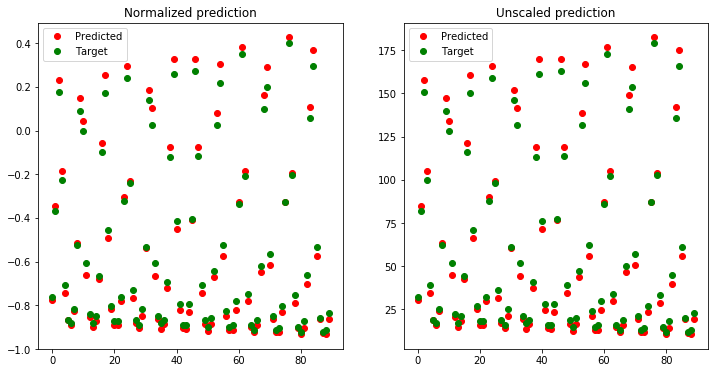

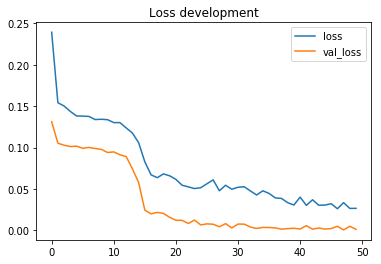

In [11]:
loaded_model = load_model()
eval_loaded_model(loaded_model, trainX, trainY, epochs=50) 
pred = model.predict(testX)
pred_unscaled = scaler.inverse_transform(pred)
testY_unscaled = scaler.inverse_transform(testY)
print("pred.shape ", pred.shape)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Normalized prediction')
plt.plot(pred, 'o', c='r', label="Predicted")
plt.plot(testY, 'o', c='g', label="Target")
plt.legend()

plt.subplot(122)
plt.title('Unscaled prediction')
plt.plot(pred_unscaled, 'o', c='r', label="Predicted")
plt.plot(testY_unscaled, 'o', c='g', label="Target")
plt.legend()
plt.show()

plt.title('Loss development')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Try to implement K-Fold crossvalidation and save the n-best models to use as ensemble

In [2]:
# TODO create a proper validation set to test ensembles

models = []
model_json ={} 
n_folds = 5
kf = KFold(n_splits=n_folds)
for train_index, test_index in kf.split(inputdata, target):
    trainX, trainY = inputdata[train_index], target[train_index]
    testX, testY = inputdata[test_index], target[test_index]

    model, history = evaluate_model(trainX, trainY, epochs=50, verbose=2)
#     model_json[train_index] = model.to_json()
#     with open("model.json", "w") as json_file:
#         json_file.write(model_json[train_index])
#     # serialize weights to HDF5
#     model.save_weights("model.h5")
#     print("Saved model to disk")
    models.append(model)
    score = model.evaluate(testX, testY)[0]
    print(score)

NameError: name 'KFold' is not defined

> 1: single=0.002, ensemble=0.002
> 2: single=0.014, ensemble=0.006
> 3: single=0.004, ensemble=0.004
> 4: single=0.002, ensemble=0.003
> 5: single=0.007, ensemble=0.003
MSE 0.006 (0.004)


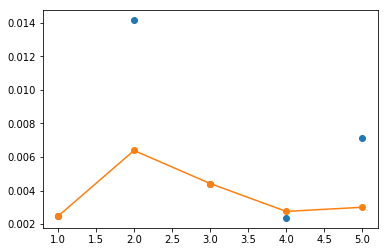

In [10]:
def ensemble_predictions(models, testX):
    # make predictions
    yhats = [model.predict(testX) for model in models]
    # median across ensemble members
    result = np.mean(yhats, axis=0)
    return result
 
# evaluate a specific number of members in an ensemble
def evaluate_n_members(models, n_models, testX, testy):
    # select a subset of members
    subset = models[:n_models]
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate accuracy
#     print("testy ", testy)
#     print("yhat ", yhat)
    return mean_squared_error(testy, yhat)
    

validationX, validationY = testX, testY
single_MSEs, ensemble_MSEs = [], []
for i in range(1, n_folds+1):
    ensemble_MSE = evaluate_n_members(models, i, validationX, validationY)
    # looks at accuracy right now (maybe bad?)
    single_MSE, _ = models[i-1].evaluate(validationX, validationY, verbose=0)
    print('> %d: single=%.3f, ensemble=%.3f' % (i, single_MSE, ensemble_MSE))
    ensemble_MSEs.append(ensemble_MSE)
    single_MSEs.append(single_MSE)
# plot score vs number of ensemble members
print('MSE %.3f (%.3f)' % (np.mean(single_MSEs), np.std(single_MSEs)))
x_axis = [i for i in range(1, n_folds+1)]
plt.plot(x_axis, single_MSEs, marker='o', linestyle='None')
plt.plot(x_axis, ensemble_MSEs, marker='o')
plt.show()

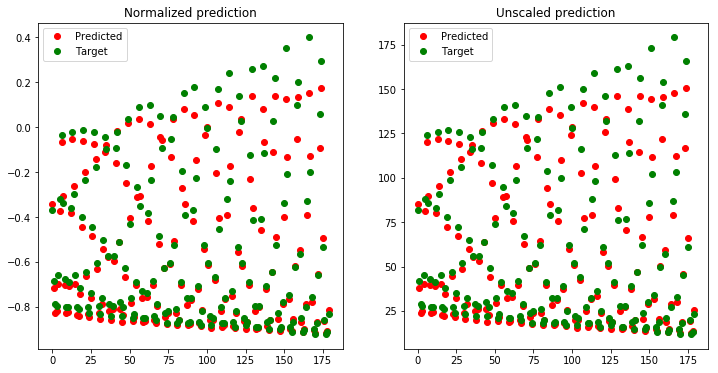

MSE:  48.05384115525234


In [11]:
pred = ensemble_predictions(models[:6], testX)
pred_unscaled = scaler.inverse_transform(pred)
testY_unscaled = scaler.inverse_transform(testY)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.title('Normalized prediction')
plt.plot(pred, 'o', c='r', label="Predicted")
plt.plot(testY, 'o', c='g', label="Target")
plt.legend()

plt.subplot(122)
plt.title('Unscaled prediction')
plt.plot(pred_unscaled, 'o', c='r', label="Predicted")
plt.plot(testY_unscaled, 'o', c='g', label="Target")
plt.legend()
plt.show()

print("MSE: ", mean_squared_error(testY_unscaled, pred_unscaled))